## Truth-matching cut based on mass of parent 

In this example, we select reconstructed kaons and pions and match them to their generated truth-level partners using the minumum angle method. We create $D^0$ candidates from the $K$ and $\pi$, both using the reco and matched truth-level tracks. This lets us calculate the reco and true parent invariant mass values. We then cut on the *true* mass of the parent, requiring it to be close to the PDG $D^0$ mass. In this way, we can select the genuine $D^0$'s in our sample, and remove the combinatorial background.

In [2]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

file = uproot.open("/eos/experiment/fcc/ee/tmp/fcc_python_tools/FCCDelphesOutput_10k.root")
tree = file['events']

Get the reco stable hadrons:

In [3]:
h_container = "efcharged.core"
h = tree.arrays(filter_name=f"{h_container}*",how="zip")
h[h_container,'p4.p'] = kinematics.calc_p(h,h_container)

Get the generated particles:

In [4]:
g_container = "genParticles.core"
g = tree.arrays(filter_name=f"{g_container}*",how="zip")
g[g_container,'p4.p'] = kinematics.calc_p(g,g_container)

Keep only the kaons and pions from the generated particles:

In [5]:
g_pi_cut = abs(g[g_container]['pdgId']) == abs(lp.pi_plus.pdgid)
g_K_cut = abs(g[g_container]['pdgId']) == abs(lp.K_plus.pdgid)
g = g[np.logical_or(g_pi_cut,g_K_cut)]

Match them based on minimum angle:

In [6]:
pairs = ak.cartesian({"reco": h[h_container], "gen": g[g_container]}, nested=True)
pairs["costheta"] = kinematics.cos_angle(pairs["reco"], pairs["gen"])
best_pair = pairs[ak.singletons(ak.argmax(pairs["costheta"], axis=2))]
h["match"] = ak.firsts(best_pair, axis=2)

Invariant mass of the reco and matched true pair, keeping only those with opposite $K$ and $\pi$ charge:

In [7]:
D = ak.cartesian({"k": h["match"][abs(h["match","reco","pdgId"])==lp.K_plus.pdgid], 
                  "pi": h["match"][abs(h["match","reco","pdgId"])==lp.pi_plus.pdgid]})

D_ID_cut = np.sign(D["k"]["reco","pdgId"]) != np.sign(D["pi"]["reco","pdgId"])
D = D[D_ID_cut]
PDG_K_m = lp.K_plus.mass/1000.
PDG_pi_m = lp.pi_plus.mass/1000.
D["mass_reco"] = kinematics.mass_2body(D["k"]["reco"], D["pi"]["reco"], PDG_K_m, PDG_pi_m)
D["mass_gen"] = kinematics.mass_2body(D["k"]["gen"], D["pi"]["gen"], PDG_K_m, PDG_pi_m)

Plot the reco $D^0$ mass for cases where the associated true particles have the correct $D^0$ mass and not

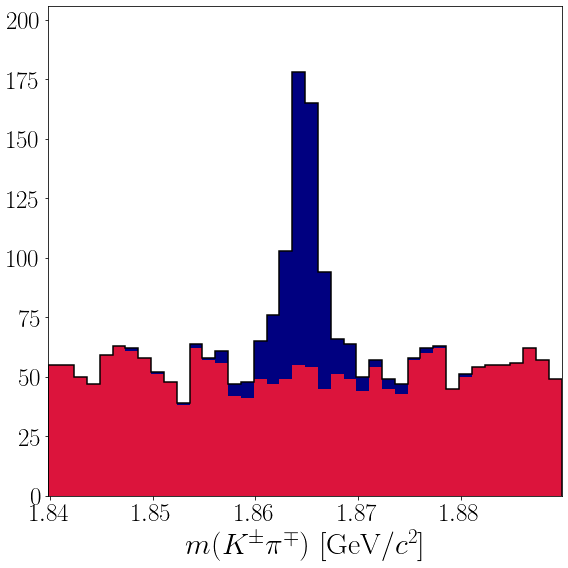

In [26]:
D0_PDG_m = lp.D_0.mass/1000.
low = D0_PDG_m - 0.025
high = D0_PDG_m + 0.025

truth_cut = abs(D["mass_gen"] - D0_PDG_m) < 0.0001

bins = 40
fig, ax = plt.subplots(figsize=(8,8))
plt.hist(ak.flatten(D["mass_reco"]),bins=bins,range=(low,high),histtype='step',color='k',linewidth=1.5)
plt.hist(ak.flatten(D["mass_reco"]),bins=bins,range=(low,high),histtype='stepfilled',color='navy',linewidth=1.5)
plt.hist(ak.flatten(D["mass_reco"][~truth_cut]),bins=bins,range=(low,high),histtype='stepfilled',color='crimson',linewidth=1.5)

plt.xlabel("$m(K^\pm\pi^\mp)$ [GeV/$c^2$]",fontsize=30)
plt.xlim(low,high)
ax.tick_params(axis='both', which='major', labelsize=25)
ymin, ymax = plt.ylim()
plt.ylim(0.,ymax*1.1)
plt.tight_layout()
plt.show()